In [71]:
import traceback
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import binary_dilation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
# AIM OF THIS NOTE BOOK

## download dataset
# https://cs.stanford.edu/~acoates/stl10/
# wget https://raw.githubusercontent.com/mttk/STL10/master/stl10_input.py
# python stl10_input.py

## add MULTIPLE lines to images.

## use above format dataset

## train yolo with images with line

In [73]:
from extract_centerline import extract_centerline
from scipy.interpolate import UnivariateSpline
def smooth_line(x,y,num=None,**kwargs):
    if num is None:
        num = len(x)
    w = np.arange(0,len(x),1)
    sx = UnivariateSpline(w,x,**kwargs)
    sy = UnivariateSpline(w,y,**kwargs)
    wnew = np.linspace(0,len(x),num)
    return sx(wnew),sy(wnew)

In [146]:
def make_line(nx=256,ny=256):
    sz = (nx,ny)
    canvas = np.zeros(sz)

    peak_num = np.random.randint(0,10,1)[0]
    for n in range(peak_num):
        x = np.random.choice(np.linspace(0, nx-1, nx),1).astype(np.int)[0]
        y = np.random.choice(np.linspace(0, ny-1, ny),1).astype(np.int)[0]
        canvas[x,y]=1

    distance = ndi.distance_transform_edt(np.logical_not(canvas))
    terrain = ndi.morphology.distance_transform_edt(distance)
    terrain = -1*terrain + -1*np.min(-1*terrain)


    prct = np.random.randint(25,75,1)[0]
    th = np.percentile(terrain.ravel(),prct)
    mask = terrain<th
    mask = np.expand_dims(mask,axis=-1)
    minlen = 50
    count0=0
    while True:
        pt = []
        for n in range(2):
            count1=0
            breakok = False
            while True:
                x = np.random.choice(np.linspace(0, nx-1, nx),1).astype(np.int)[0]
                y = np.random.choice(np.linspace(0, ny-1, ny),1).astype(np.int)[0]
                z = 0
                if len(pt)==0 and mask[x,y,z] == 1:
                    breakok = True
                if len(pt)==1 and mask[x,y,z] == 1 and \
                    np.abs(x-pt[0][0]) > minlen and np.abs(y-pt[0][1]) > minlen:
                    breakok = True
                if breakok:
                    break
                count1+=1
                if count1>100:
                    raise LookupError('ok1')
            pt.append((x,y,z))
        start_point = pt[0]
        end_point = pt[1]
        line = extract_centerline(mask,start_point,end_point)
        linexorg,lineyorg,linez=line
        smothing_factor=np.random.rand()*1000
        try:
            linex,liney = smooth_line(linexorg,lineyorg,num=100*len(linexorg),s=smothing_factor)
        except:
            pass
        if len(linexorg) > 5:
            break
            
        count0+=1
        if count0>200:
            raise LookupError('ok0')
            
    mask = mask.squeeze()
    return mask, terrain, linexorg,lineyorg, linex, liney


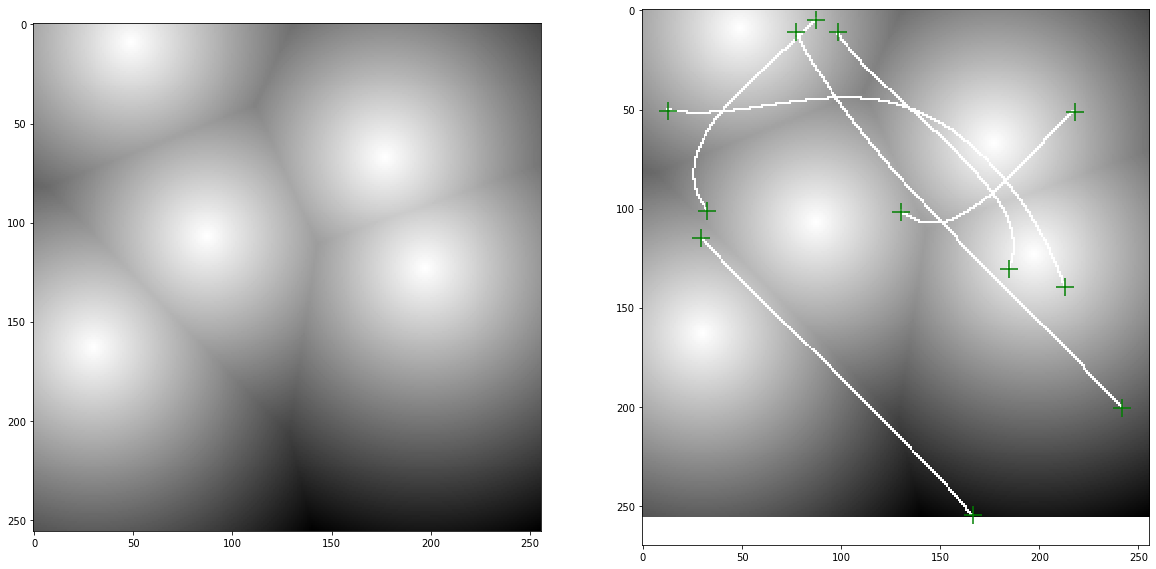

In [219]:
# create dataset with multiple lines

def make_one_sample(isplot=False,fignum=0):
    
    maskorg, terrain, linexorg,lineyorg, linex, liney = make_line(nx=256,ny=256)
    myimage = np.copy(terrain)
    mymax = np.max(myimage)
    linmax = np.random.randint(0,10,1)[0]
    container = []
    for x in range(linmax):
        _, _, linexorg,lineyorg, linex, liney = make_line()
        mask = np.zeros(myimage.shape)
        for x,y in zip(linex,liney):
            try:
                myimage[x.astype(int),y.astype(int)]=mymax
                mask[x.astype(int),y.astype(int)]=1
            except:
                pass
        endpoints = [[linex[0], liney[0]],[linex[-1], liney[-1]]]
        container.append({
            'mask':mask,
            'endpoints':endpoints,
        })
    if isplot:
        plt.figure(fignum,figsize=(20,20))
        plt.subplot(121)
        plt.imshow(terrain,cmap='gray')
        plt.subplot(122)
        plt.imshow(myimage,cmap='gray')
        for item in container:
            plt.scatter(item['endpoints'][0][1],item['endpoints'][0][0],300,'green',marker='+')
            plt.scatter(item['endpoints'][1][1],item['endpoints'][1][0],300,'green',marker='+')
        plt.xlim(0,)
    return terrain, container

terrain, container = make_one_sample(isplot=True)

Traceback (most recent call last):
  File "<ipython-input-223-e6f8796616aa>", line 3, in <module>
    terrain, container = make_one_sample(isplot=True,fignum=n)
  File "<ipython-input-219-463e1be9e524>", line 10, in make_one_sample
    _, _, linexorg,lineyorg, linex, liney = make_line()
  File "<ipython-input-146-57c45918db4d>", line 40, in make_line
    raise LookupError('ok1')
LookupError: ok1
Traceback (most recent call last):
  File "<ipython-input-223-e6f8796616aa>", line 3, in <module>
    terrain, container = make_one_sample(isplot=True,fignum=n)
  File "<ipython-input-219-463e1be9e524>", line 10, in make_one_sample
    _, _, linexorg,lineyorg, linex, liney = make_line()
  File "<ipython-input-146-57c45918db4d>", line 40, in make_line
    raise LookupError('ok1')
LookupError: ok1


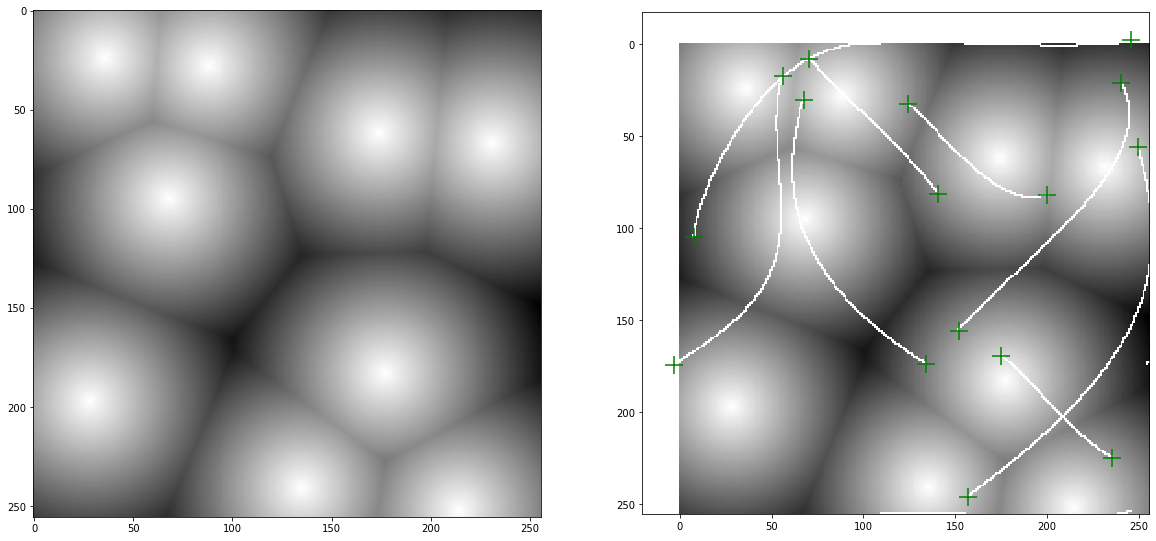

In [223]:
for n in range(3):
    try:
        terrain, container = make_one_sample(isplot=True,fignum=n)
    except:
        traceback.print_exc()